### This is just for storing things I found probably shouldn't be clean but warrant due diligence follow up or possible areas of improvement

In [35]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

## Lets load in the metrics data for use

In [36]:
# Path to your SQLite database
db_path = "Subscriptions.db"

# Connect to the database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Find all metrics subscription data tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name LIKE 'metrics_subscription_data_%';")
tables = cursor.fetchall()

if not tables:
    print("No metrics_subscription_data tables found in the database.")
else:
    # Extract table names and sort them to find the most recent one
    metrics_tables = [table[0] for table in tables]
    latest_metrics_table = sorted(metrics_tables)[-1]
    
    print(f"Loading data from the most recent metrics table: '{latest_metrics_table}'")
    
    # Query to get all data from the most recent table
    query = f"SELECT * FROM {latest_metrics_table}"
    
    # Load the data into a pandas DataFrame
    df = pd.read_sql_query(query, conn)
    
    # Display basic information about the DataFrame
    print(f"\nLoaded {len(df)} rows and {len(df.columns)} columns")
    print("\nDataFrame shape:", df.shape)
    print("\nColumn names:", list(df.columns))
    print("\nFirst 5 rows:")
    print(df.head())
    
    # Show summary statistics for key metrics columns
    print("\nKey metrics summary:")
    metric_columns = ['payment_periods', 'avg_monthly_payment', 'expansion_ratio', 'has_expanded', 'current_mrr']
    print(df[metric_columns].describe())

# Close the connection
conn.close()

Loading data from the most recent metrics table: 'metrics_subscription_data_20230116'

Loaded 134610 rows and 21 columns

DataFrame shape: (134610, 21)

Column names: ['oid', 'provider', 'total_charges', 'signup_date', 'is_canceled', 'is_active', 'is_delinquent', 'conversion_date', 'cancellation_date', 'current_mrr', 'personal_person_geo_country', 'converted', 'payment_periods', 'avg_monthly_payment', 'expansion_ratio', 'has_expanded', 'price_tier', 'conversion_speed', 'conversion_speed_category', 'conversion_cohort', 'signup_cohort']

First 5 rows:
               oid provider  total_charges          signup_date  is_canceled  \
0  273624174263463    apple          10.94  2021-04-20 00:00:00            1   
1  532534633483904    apple          10.92  2021-04-20 00:00:00            1   
2  623527156674739    apple           0.00  2021-04-20 00:00:00            0   
3  441616357320658    apple          90.30  2021-04-20 00:00:00            0   
4  189644194376891    apple          79.98  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


## Now lets take a look at customers who:
- Are active and have current MRR but no total charges
- Have negative total charges

In [37]:


# Assuming df is already loaded with the subscription data and has payment_periods calculated

# 1. Customers with zero charges but long activity (at least 3 months)
zero_charges_df = df[
    (df['total_charges'] == 0) & 
    (df['is_active'] == 1) & 
    (df['converted'] == 1) &
    (df['conversion_date'].notna()) &
    (pd.to_datetime(df['conversion_date']) <= pd.Timestamp('2022-10-16'))
].sort_values('conversion_date')

# 2. Customers with negative charges
negative_charges_df = df[df['total_charges'] < 0].sort_values('total_charges')

# ========================= ANALYSIS OF ZERO CHARGES CUSTOMERS =========================
print("\n=== ANALYSIS OF ZERO CHARGES CUSTOMERS ===")
print(f"Number of customers with zero charges but long activity: {len(zero_charges_df)}")

print("\nProvider distribution:")
provider_counts = zero_charges_df['provider'].value_counts()
print(provider_counts)

print("\nGeography distribution (top 10):")
country_counts = zero_charges_df['personal_person_geo_country'].value_counts().head(10)
print(country_counts)

# Calculate activity months
end_date = datetime(2023, 1, 16)
zero_charges_df['activity_months'] = (end_date - pd.to_datetime(zero_charges_df['conversion_date'])).dt.days / 30

print("\nActivity period statistics (months):")
print(zero_charges_df['activity_months'].describe())

print("\nSample of long-term zero charge customers:")
print(zero_charges_df.sort_values('activity_months', ascending=False).head(10)[
    ['oid', 'provider', 'conversion_date', 'current_mrr', 'is_active', 'activity_months', 'payment_periods']
])




=== ANALYSIS OF ZERO CHARGES CUSTOMERS ===
Number of customers with zero charges but long activity: 455

Provider distribution:
provider
apple    455
Name: count, dtype: int64

Geography distribution (top 10):
personal_person_geo_country
United States of America                                353
China                                                    16
United Kingdom of Great Britain and Northern Ireland     11
Germany                                                   8
Canada                                                    5
Argentina                                                 5
France                                                    4
Australia                                                 4
Hong Kong                                                 4
Spain                                                     4
Name: count, dtype: int64

Activity period statistics (months):
count    455.000000
mean       7.406813
std        2.798955
min        3.066667
25%        4.8166

In [38]:

# Calculate potential missed revenue
zero_charges_df['potential_missed_revenue'] = zero_charges_df['current_mrr'] * zero_charges_df['payment_periods']
total_missed_revenue = zero_charges_df['potential_missed_revenue'].sum()

print(f"\nPotential Missed Revenue Analysis:")
print(f"Total potential missed revenue: ${total_missed_revenue:.2f}")
print(f"Average missed revenue per customer: ${total_missed_revenue/len(zero_charges_df):.2f}")

# Check how many have non-zero current MRR
non_zero_mrr_count = len(zero_charges_df[zero_charges_df['current_mrr'] > 0])
print(f"Number of zero-charge customers with non-zero current MRR: {non_zero_mrr_count} ({non_zero_mrr_count/len(zero_charges_df)*100:.2f}%)")

# Potential revenue from just customers with non-zero current MRR
if non_zero_mrr_count > 0:
    non_zero_mrr_df = zero_charges_df[zero_charges_df['current_mrr'] > 0]
    non_zero_missed_revenue = non_zero_mrr_df['potential_missed_revenue'].sum()
    print(f"Potential missed revenue from just customers with non-zero current MRR: ${non_zero_missed_revenue:.2f}")

print("\nSample of long-term zero charge customers:")
print(zero_charges_df.sort_values('potential_missed_revenue', ascending=False).head(10)[
    ['oid', 'provider', 'conversion_date', 'current_mrr', 'is_active', 'payment_periods', 'potential_missed_revenue']
])



Potential Missed Revenue Analysis:
Total potential missed revenue: $17686.57
Average missed revenue per customer: $38.87
Number of zero-charge customers with non-zero current MRR: 455 (100.00%)
Potential missed revenue from just customers with non-zero current MRR: $17686.57

Sample of long-term zero charge customers:
                   oid provider      conversion_date  current_mrr  is_active  \
32829  504582242443575    apple  2022-01-23 00:00:00         5.67          1   
27546  448627612340651    apple  2022-01-13 00:00:00         5.00          1   
15602  161634843615541    apple  2022-01-15 00:00:00         5.00          1   
26926  784423327131691    apple  2022-01-03 00:00:00         5.00          1   
36588  623539211089405    apple  2022-02-06 00:00:00         5.41          1   
40471  700459018227684    apple  2022-02-19 00:00:00         5.82          1   
35695  658474539831054    apple  2022-02-03 00:00:00         5.22          1   
40724  203638495826292    apple  2022-0

In [39]:

# ========================= ANALYSIS OF NEGATIVE CHARGES CUSTOMERS =========================
print("\n=== ANALYSIS OF NEGATIVE CHARGES CUSTOMERS ===")
print(f"Number of customers with negative charges: {len(negative_charges_df)}")

print("\nProvider distribution:")
neg_provider_counts = negative_charges_df['provider'].value_counts()
print(neg_provider_counts)

print("\nSum of negative charges:")
total_negative = negative_charges_df['total_charges'].sum()
print(f"${total_negative:.2f}")

print("\nDistribution of negative charges:")
print(negative_charges_df['total_charges'].describe())

print("\nCancellation status:")
cancel_status = negative_charges_df['is_canceled'].value_counts()
print(cancel_status)
print(f"Percentage cancelled: {cancel_status.get(1, 0) / len(negative_charges_df) * 100:.2f}%")

print("\nGeography distribution (top 10):")
neg_country_counts = negative_charges_df['personal_person_geo_country'].value_counts().head(10)
print(neg_country_counts)

print("\nSample of customers with most negative charges:")
print(negative_charges_df.sort_values('total_charges').head(10)[
    ['oid', 'provider', 'total_charges', 'conversion_date', 'cancellation_date', 'current_mrr', 'is_canceled', 'payment_periods']
])



=== ANALYSIS OF NEGATIVE CHARGES CUSTOMERS ===
Number of customers with negative charges: 391

Provider distribution:
provider
apple     383
google      8
Name: count, dtype: int64

Sum of negative charges:
$-419.62

Distribution of negative charges:
count    391.000000
mean      -1.073197
std        7.369842
min     -119.980000
25%       -0.460000
50%       -0.210000
75%       -0.080000
max       -0.010000
Name: total_charges, dtype: float64

Cancellation status:
is_canceled
0    247
1    144
Name: count, dtype: int64
Percentage cancelled: 36.83%

Geography distribution (top 10):
personal_person_geo_country
United Kingdom of Great Britain and Northern Ireland    67
Germany                                                 50
Canada                                                  30
France                                                  23
Australia                                               21
China                                                   21
Italy                        

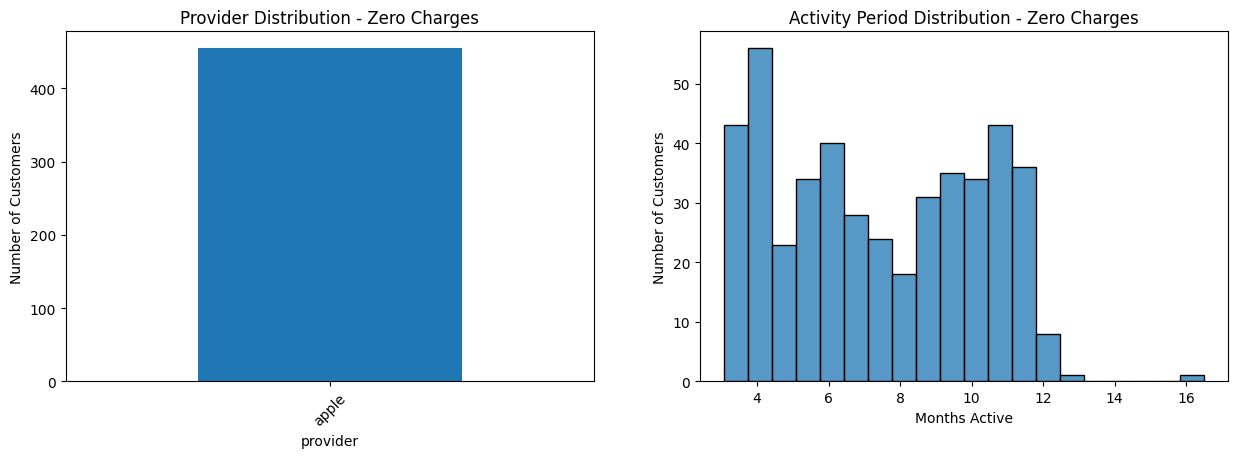

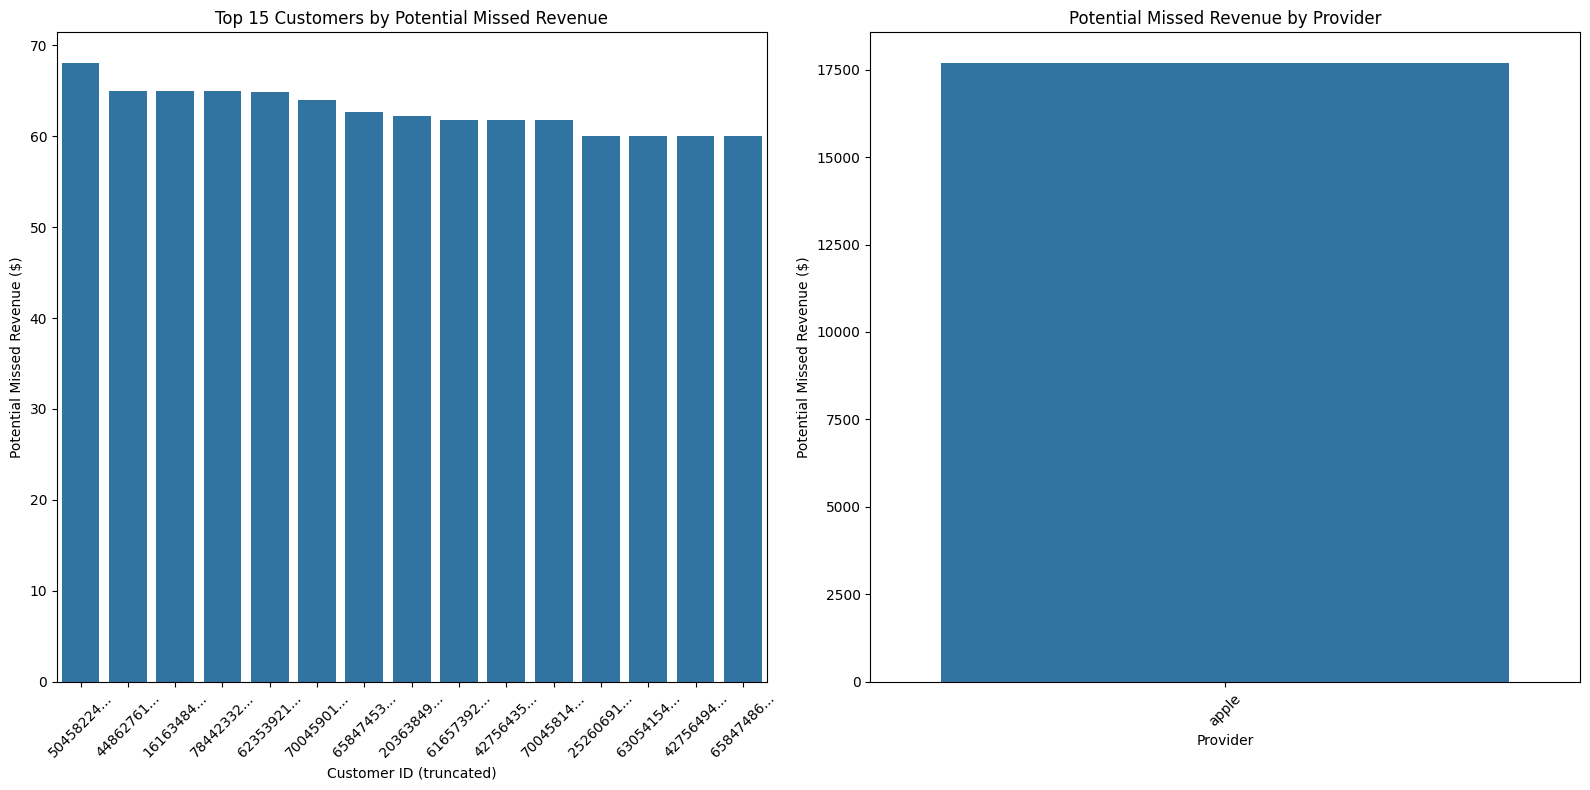

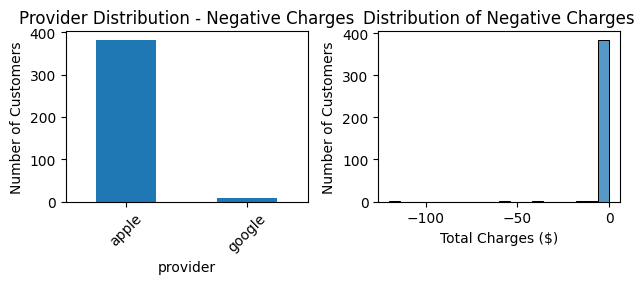

In [40]:

# ========================= VISUALIZATIONS =========================

# Setup for plotting
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)

# 1. Provider distribution for zero charges
provider_counts.plot(kind='bar')
plt.title('Provider Distribution - Zero Charges')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)

# 2. Activity months histogram for zero charges
plt.subplot(2, 2, 2)
sns.histplot(zero_charges_df['activity_months'], bins=20)
plt.title('Activity Period Distribution - Zero Charges')
plt.xlabel('Months Active')
plt.ylabel('Number of Customers')

# Add a new figure for missed revenue analysis
plt.figure(figsize=(16, 8))

# If there are customers with non-zero MRR
if len(zero_charges_df[zero_charges_df['current_mrr'] > 0]) > 0:
    plt.subplot(1, 2, 1)
    # Get top 15 customers by missed revenue for visualization
    top_missed_revenue = zero_charges_df.sort_values('potential_missed_revenue', ascending=False).head(15)
    
    # Plot missed revenue by customer (top 15)
    sns.barplot(x=top_missed_revenue['oid'].astype(str).str[:8] + '...', 
                y='potential_missed_revenue', data=top_missed_revenue)
    plt.title('Top 15 Customers by Potential Missed Revenue')
    plt.ylabel('Potential Missed Revenue ($)')
    plt.xlabel('Customer ID (truncated)')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    # Plot missed revenue by provider
    missed_by_provider = zero_charges_df.groupby('provider')['potential_missed_revenue'].sum().sort_values(ascending=False)
    sns.barplot(x=missed_by_provider.index, y=missed_by_provider.values)
    plt.title('Potential Missed Revenue by Provider')
    plt.ylabel('Potential Missed Revenue ($)')
    plt.xlabel('Provider')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    #plt.savefig('missed_revenue_analysis.png')
    plt.show()
    plt.close()

# 3. Provider distribution for negative charges
plt.subplot(2, 2, 3)
neg_provider_counts.plot(kind='bar')
plt.title('Provider Distribution - Negative Charges')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)

# 4. Negative charges distribution
plt.subplot(2, 2, 4)
sns.histplot(negative_charges_df['total_charges'], bins=20)
plt.title('Distribution of Negative Charges')
plt.xlabel('Total Charges ($)')
plt.ylabel('Number of Customers')

plt.tight_layout()
#plt.savefig('zero_negative_charges_analysis.png')
plt.show()
plt.close()



# ========================= RECOMMENDATIONS =========================

## For Zero Charges Customers:
- Investigate why these customers have zero charges despite long activity
- Check if these are internal accounts, testing accounts, or special arrangements
- Verify if there is a billing system issue for specific providers
- Consider implementing a review process for accounts with $0 charges after 3+ months

## For Negative Charges Customers:
- Looks like a reasonable refund population but could be worth looking into outliers with high refunds to get ahead of fraud
- Analyze the refund patterns to understand the reasons
- Check if specific providers or countries have higher refund rates
- For large negative amounts, conduct a detailed review of individual cases
- Consider adding a classification system for refund reasons to track patterns

### Lets now look at the places where sign up date is after conversion date which doesnt make sense, probably data quality issue

In [41]:
print(df[df['signup_date'] > df['conversion_date']].count())
print(df[df['signup_date'] > df['conversion_date']])

oid                            16
provider                       16
total_charges                  16
signup_date                    16
is_canceled                    16
is_active                      16
is_delinquent                  16
conversion_date                16
cancellation_date              16
current_mrr                    16
personal_person_geo_country    16
converted                      16
payment_periods                16
avg_monthly_payment            16
expansion_ratio                16
has_expanded                   16
price_tier                     16
conversion_speed               16
conversion_speed_category       0
conversion_cohort              16
signup_cohort                  16
dtype: int64
                             oid provider  total_charges          signup_date  \
112561  GPA.3319-9266-5306-16298   google           8.38  2022-11-19 00:00:00   
114687  GPA.3371-4654-4661-23422   google          64.83  2022-11-23 00:00:00   
118308  GPA.3382-4129-7346-601